In [44]:
import os
import numpy as np
import cv2
import keras
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
from matplotlib.pyplot import imread

In [29]:
train_dir = 'data_cascaded'
os.listdir(data_path)

['not_pretty', 'pretty']

In [30]:
# defining paramters
fast_run = False
batch_size = 8
img_height = 80
img_width = 80
img_channels = 3

In [33]:
# loading data

labels_dict = {
    'not_pretty': 0,
    'pretty': 1,
}

def load_data():
    """
    Loads data and preprocess. Returns train and test data along with labels.
    """
    images = []
    labels = []
    size = img_width,img_height
    print("LOADING DATA FROM : ",end = "")
    for folder in os.listdir(train_dir):
        print(folder, end = ' | ')
        for image in os.listdir(train_dir + "/" + folder):
            temp_img = cv2.imread(train_dir + '/' + folder + '/' + image)
            if(type(temp_img) is np.ndarray):
                temp_img = cv2.resize(temp_img, size)
                images.append(temp_img)
                labels.append(labels_dict[folder])
    
    images = np.array(images)
    labels = np.array(labels)
    
    # saving numpy file
    np.save('numpy/images.npy', images)
    np.save('numpy/labels.npy', labels)
    print('Numpy file saved success...')
    
    # Normalizing image data.
    images = images.astype('float32')/255.0
    
    # converting labels to one hot format.

    labels = keras.utils.to_categorical(labels)
    
    # creating training and test data by splitting original data into 70% of training data and 30% testing data.
    X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size = 0.3)
    
    print()
    print('Loaded', len(X_train),'images for training,','Train data shape =',X_train.shape)
    print('Loaded', len(X_test),'images for testing','Test data shape =',X_test.shape)
    
    return X_train, X_test, Y_train, Y_test

In [34]:
X_train, X_test, Y_train, Y_test = load_data()

LOADING DATA FROM : not_pretty | pretty | Numpy file saved success...

Loaded 666 images for training, Train data shape = (666, 80, 80, 3)
Loaded 286 images for testing Test data shape = (286, 80, 80, 3)


In [39]:
# define model

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, img_channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 78, 78, 32)        896       
_________________________________________________________________
batch_normalization_3 (Batch (None, 78, 78, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 39, 39, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 37, 37, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)       

In [40]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [45]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [46]:
epochs= 50
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_split = 0.3)

Train on 466 samples, validate on 200 samples
Epoch 1/50
466/466 [==============================] - 39s 83ms/step - loss: 1.4477 - accuracy: 0.5536 - val_loss: 0.7672 - val_accuracy: 0.4300
Epoch 2/50
466/466 [==============================] - 32s 69ms/step - loss: 1.2350 - accuracy: 0.5343 - val_loss: 0.8459 - val_accuracy: 0.5150
Epoch 3/50
466/466 [==============================] - 32s 69ms/step - loss: 1.0915 - accuracy: 0.5536 - val_loss: 1.4054 - val_accuracy: 0.4350
Epoch 4/50
466/466 [==============================] - 32s 69ms/step - loss: 0.9905 - accuracy: 0.5451 - val_loss: 0.8842 - val_accuracy: 0.4550
Epoch 5/50
466/466 [==============================] - 34s 72ms/step - loss: 0.8795 - accuracy: 0.5880 - val_loss: 0.8374 - val_accuracy: 0.5250
Epoch 6/50
466/466 [==============================] - 36s 77ms/step - loss: 0.8087 - accuracy: 0.6373 - val_loss: 0.8266 - val_accuracy: 0.5100
Epoch 7/50
466/466 [==============================] - 36s 77ms/step - loss: 0.8134 - accur

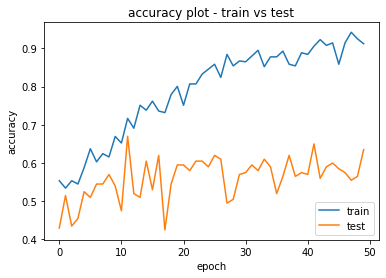

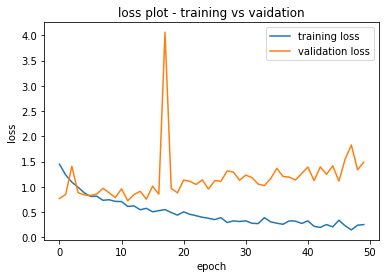

In [47]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'test'], loc='lower right')
plt.title('accuracy plot - train vs test')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'validation loss'], loc = 'upper right')
plt.title('loss plot - training vs vaidation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [48]:
evaluate_metrics = model.evaluate(X_test, Y_test)
print("\nEvaluation Accuracy = ", "{:.2f}%".format(evaluate_metrics[1]*100),"\nEvaluation loss = " ,"{:.6f}".format(evaluate_metrics[0]))

286/286 [==============================] - 5s 18ms/step

Evaluation Accuracy =  63.29% 
Evaluation loss =  1.362828


In [50]:
# Saving the model
model_json = model.to_json()
with open("model/model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights('model/model.h5')
print('model saved success')

model saved success


In [51]:
labels =[ label for label in labels_dict]

In [239]:
def predict(img):
    img = cv2. resize(img, (img_width, img_height))
    img = img.reshape(1, img_width, img_height, 3)
    my_pred = np.argmax(model.predict(img))
    pred_class = labels[my_pred]
    return pred_class

In [236]:
# Load the cascade
face_cascade = cv2.CascadeClassifier('xml/haarcascade_frontalface_default.xml')

In [297]:
def extract_n_predict(img_path):
    # Read the input image
    img = imread(img_path)
    # Convert into grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.3, 4)
    
    if faces is ():
        print("Sorry! Unable to detect face or it might contains filter")
    else:
        results = []
        # Draw rectangle around the faces
        for (x, y, w, h) in faces:
            img_crop = img[y:y+h, x:x+w]    
            cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
            my_pred = predict(img_crop)
            results.append(my_pred)
            plt.title(str(results))
        plt.imshow(img)

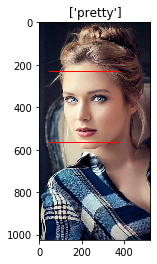

In [300]:
extract_n_predict('test_images/girl.jpg')

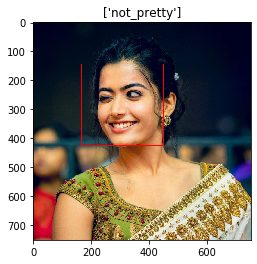

In [307]:
extract_n_predict('test_images/rash.jpg')

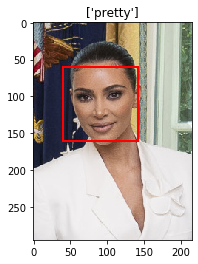

In [309]:
extract_n_predict('test_images/kim.jpg')

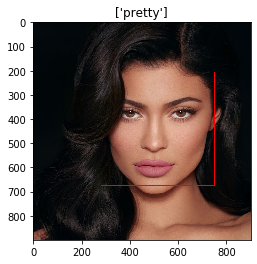

In [310]:
extract_n_predict('test_images/kylie.jpg')

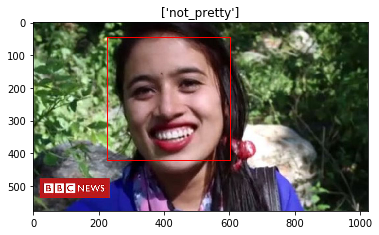

In [312]:
extract_n_predict('test_images/tarkali.jpg')

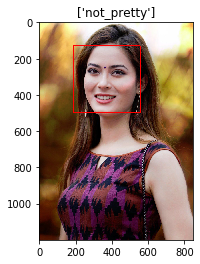

In [313]:
extract_n_predict('test_images/shrinkala.jpg')

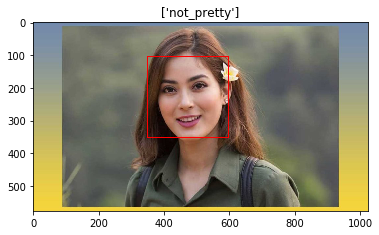

In [315]:
extract_n_predict('test_images/shrinkala2.jpg')

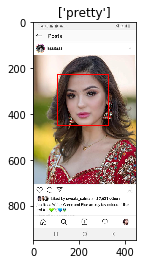

In [316]:
extract_n_predict('test_images/jasita.jpg')

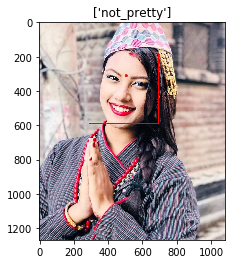

In [314]:
extract_n_predict('test_images/bg.jpg')